The objective of this notebook is to analyze Ames Housing data and use several regression models to predict house prices.

The data contains almost every feature of a house in Ames, Iowa. The features consist of the number of bedrooms, location, surroundings, etc. The data is from Kaggle's Housing Prices: Advanced Regression Techniques. It comes with a train set, test set, and data dictionary.

[Ames Housing Data](https://www.kaggle.com/c/house-prices-advanced-regression-techniques "Ames Housing Data")

Steps to accomplish the objective:

1. [Import Data](#import-data)
2. [Exploratory analysis](#exploratory-analysis)
3. [Data cleaning](#data-cleaning)
4. [Machine learning](#machine-learning)
 - [Simple Linear model](#simple-linear-model)
 - [Ridge Regression](#ridge-regression)
 - [XGBoost](#xgboost)
5. [Conclusion](#conlusion)

# Import Data

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Exploratory Analysis

Quick look at data

In [2]:
print train.head(10)
print train.shape

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities    ...     PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN    NaN         NaN       0   
1         Lvl    AllPub

Check if test columns equal train columns and they do.

In [3]:
test.columns == train.columns[:-1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

Look at the data types. Object has the highest count.

In [4]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

Density plots for the numeric features. There does not seem to be anything out of the ordinary.

Some interesting facts:
- most homes were built in year 2000
- most homes have about 1000 sqft for the 1st floor
- most homes sold for under $200,000

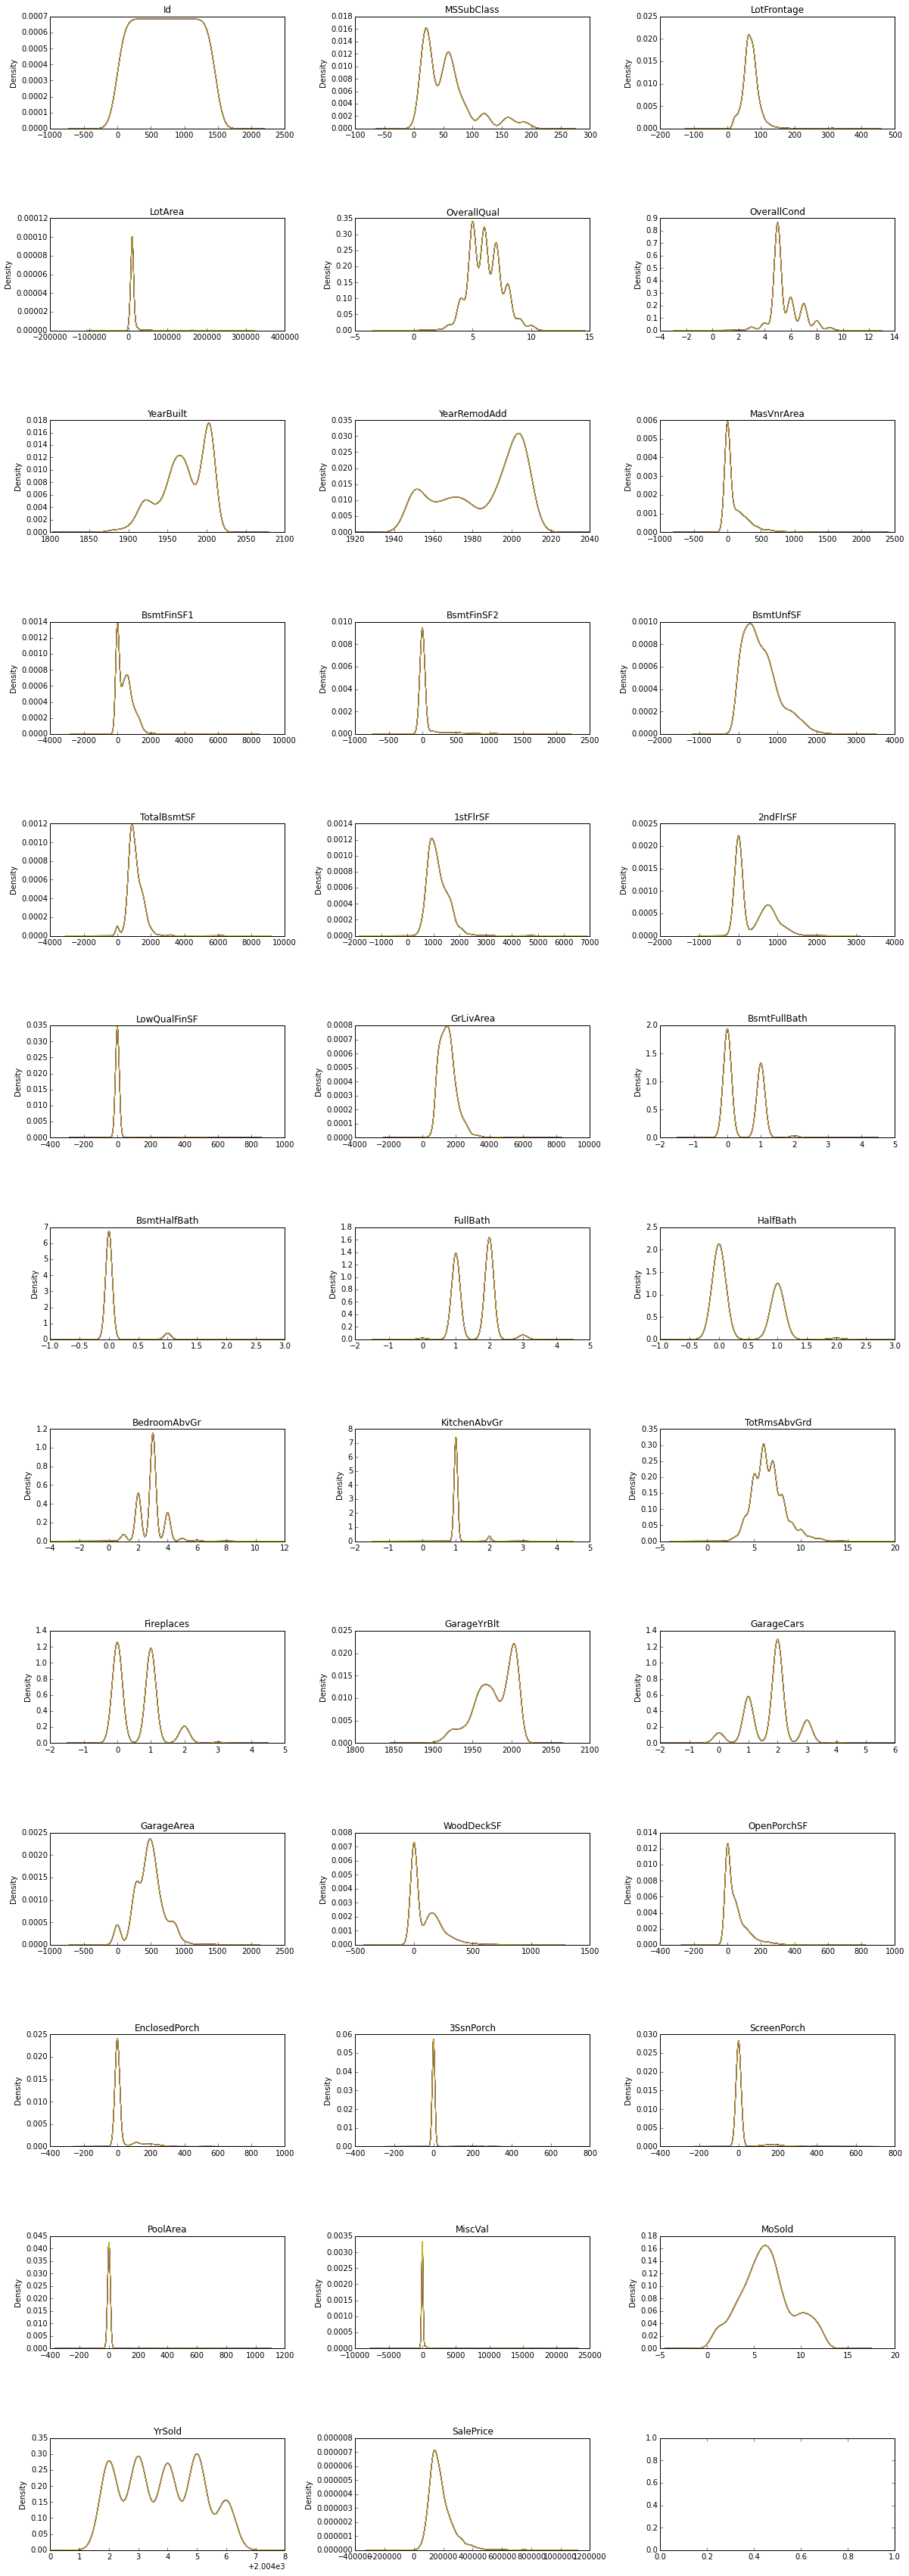

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

train.select_dtypes(include=['float64','int64'])
# num_features = train.dtypes[train.dtypes in ['int64','float64']].index
n_features1 = 10
n_rows = 13
num_df = train.select_dtypes(include=['float64','int64'])

fig, axs = plt.subplots(n_rows,3, figsize = (20,60))

fig.subplots_adjust(hspace=.8, wspace=.3)

for k in axs:
    for i,j in zip(num_df, axs.flat):
        g = num_df[i].plot.kde(ax = j, title = i)
        g.get_xaxis().tick_bottom()
        g.get_yaxis().tick_left()

Same as before but bar plots for categorical features. Interesting facts:

- Most homes are in North Ames
- The ones with garages are attached to the house
- Most are normal sales

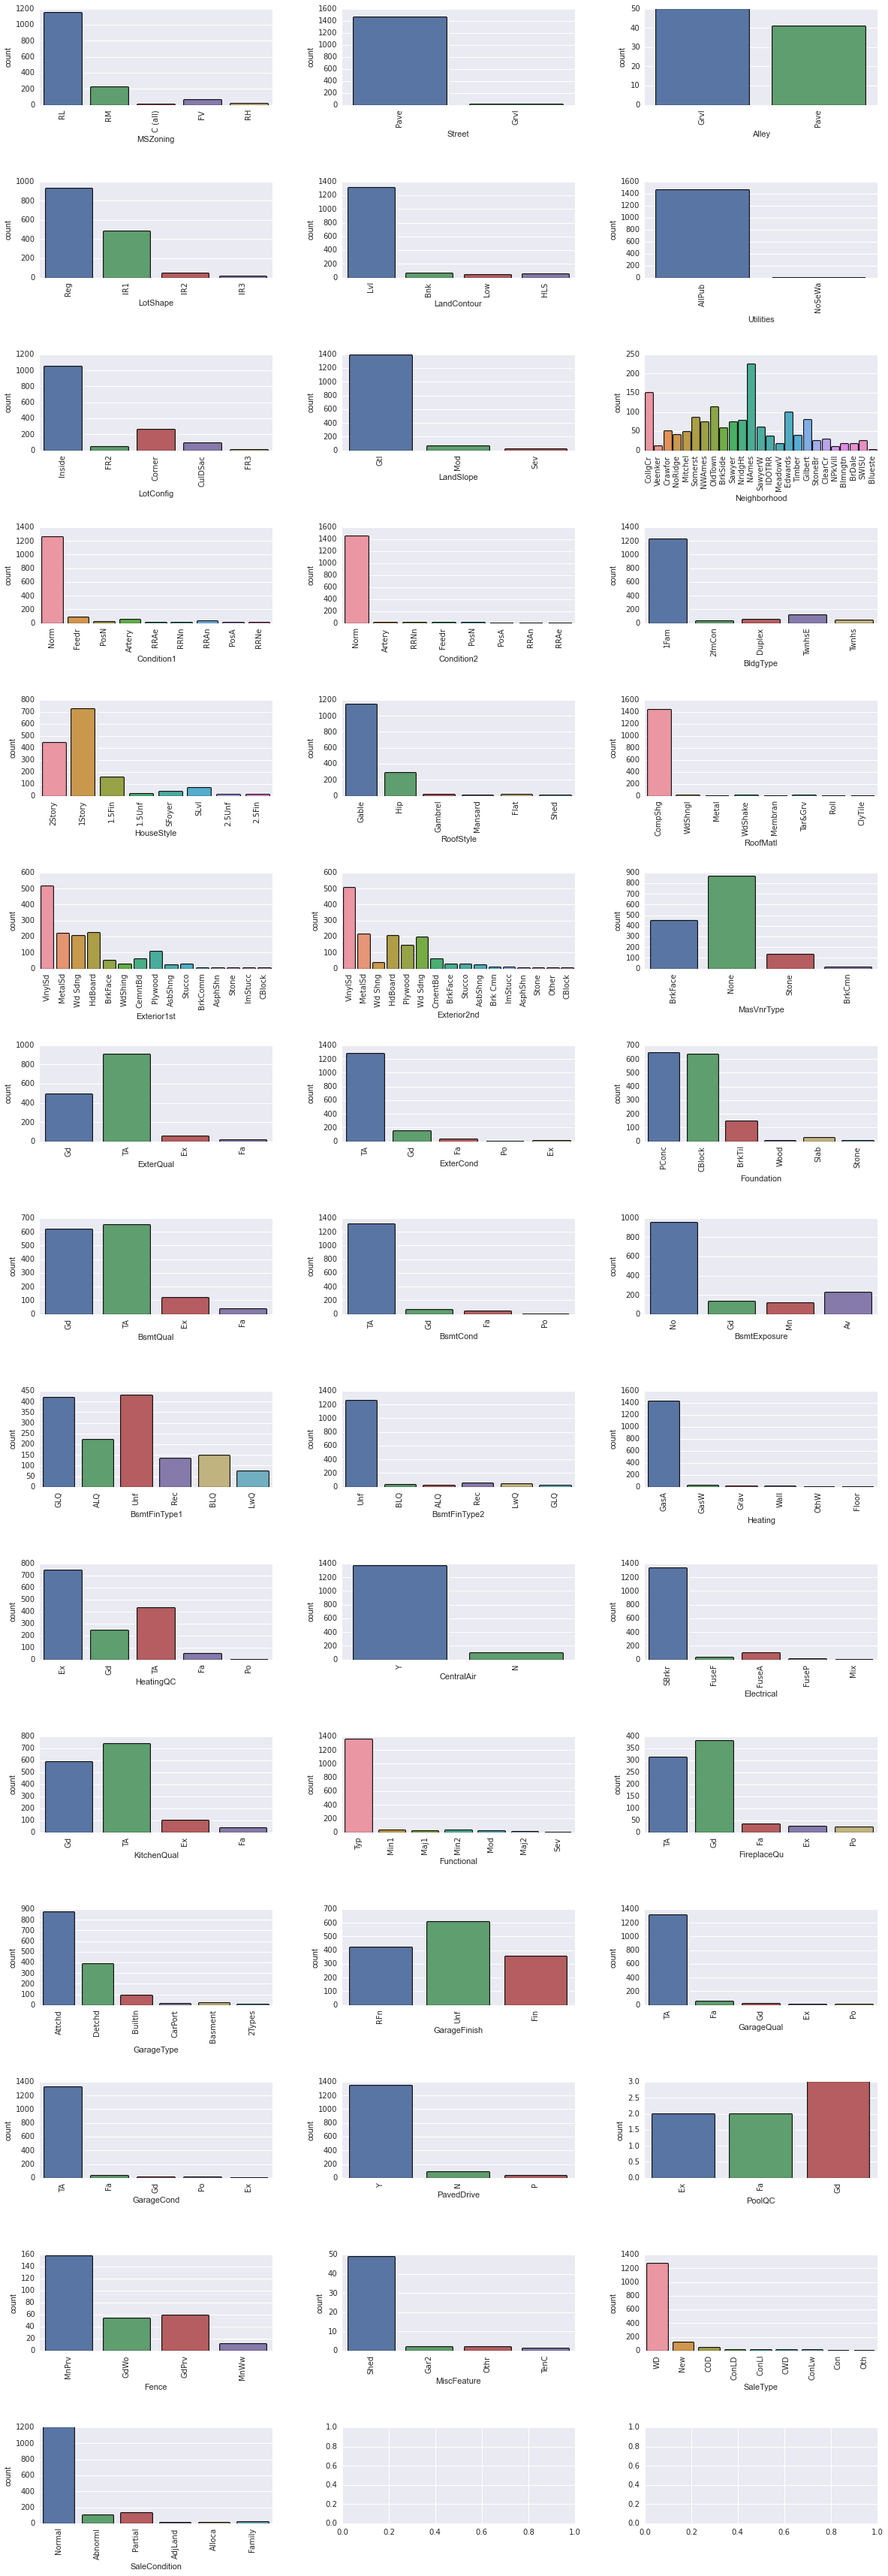

In [6]:
import seaborn as sns
#object features
object_features = train.dtypes[train.dtypes == 'object'].index
n_features1 = 10
n_rows = 15
object_df = train[object_features]

fig, axs = plt.subplots(n_rows,3, figsize = (20,60))

fig.subplots_adjust(hspace=.8, wspace=.3)


for k in axs:
    for i,j in zip(object_features, axs.flat):
        g = sns.countplot(x=i, data=object_df, ax=j)
        plt.setp(j.get_xticklabels(), rotation=90)

Let's check out the correlation each numeric feature has with the target (SalePrice). OverallQual has the highest
correlation with .79 and BsmtFinSF2 has lowest with 0.11.

In [7]:
numeric_features = train.dtypes[train.dtypes != 'object'].index
pearson = train[numeric_features].corr(method='pearson')
corr_with_target = pearson.ix[-1][1:-1]
corr_with_target = corr_with_target[abs(corr_with_target).argsort()[::-1]]
print corr_with_target

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass      -0.084284
OverallCond     -0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
Name: SalePrice, dtype: float64


Let's check the correlation between each feature.
There are some features that have high correlation:

- TotalBsmtSF and 1stFlrSF have .82 correlation
- YearBuilt and GarageYrBlt have .83 correlation
- GrLivArea and TotRmsAbvGrd have .83 correlation
- GarageCars and GarageArea have .88 correlation
- BsmtFinSF2 and BsmtUntSF have -.5 correlation highest negative


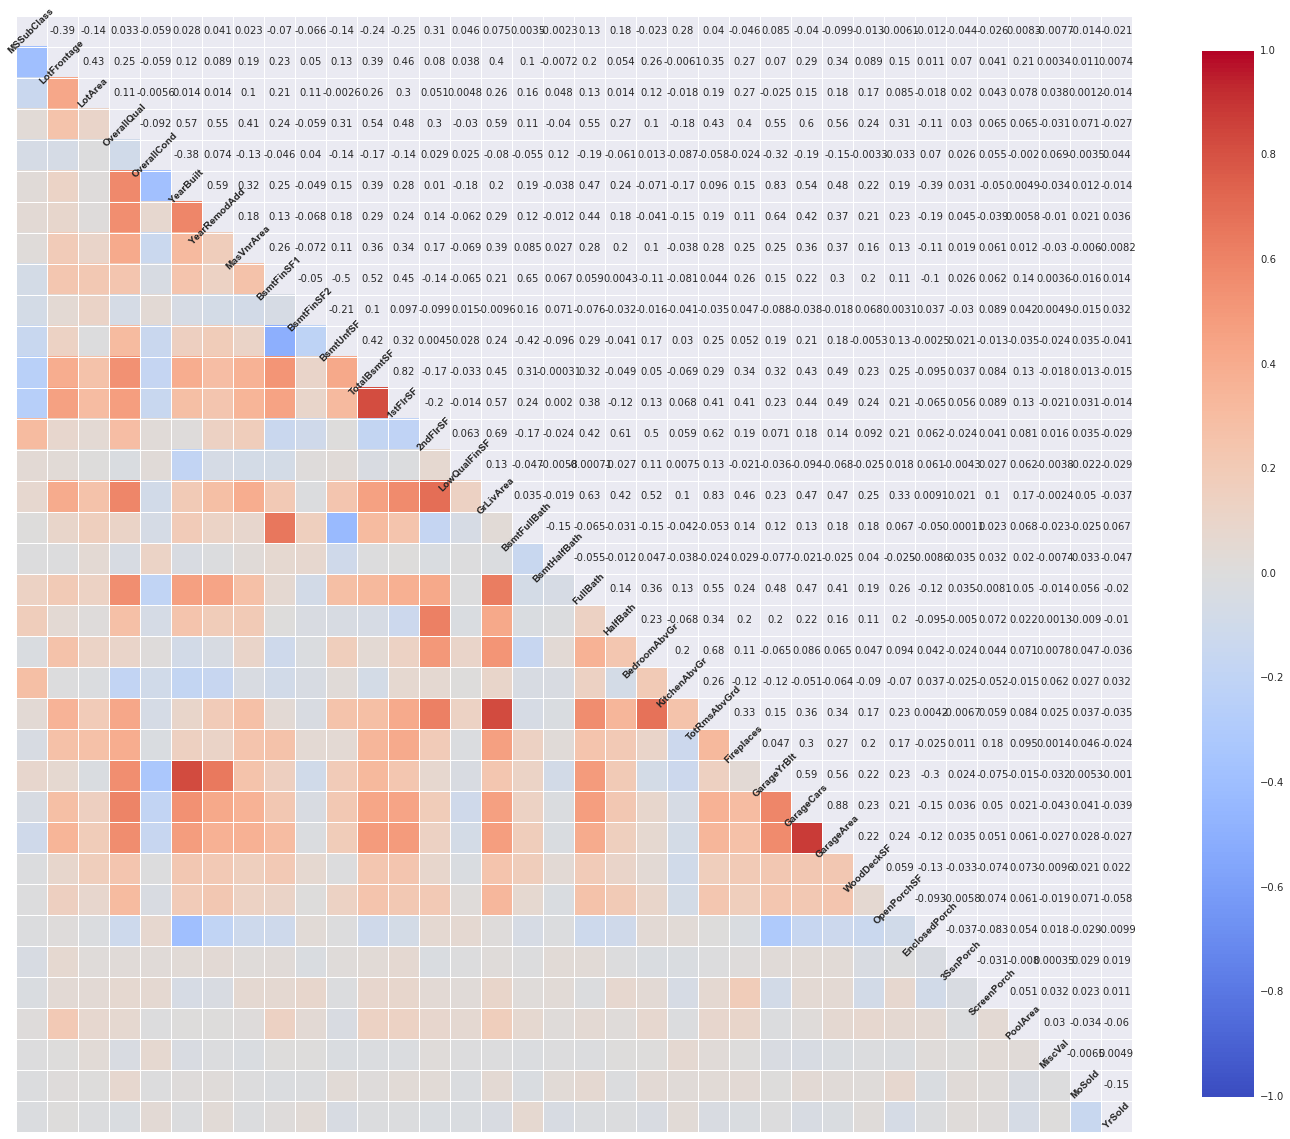

In [8]:
# make a plot of specified dimension (in inches), just a 1x1 subplot
fig, ax = plt.subplots(figsize=(25, 25))
# pass the axis to draw on
sns.corrplot(train[numeric_features[1:-1]], ax=ax)

# Data Cleaning

Begin with removing features that have multi-collinearity. Out of the 4 pairs, remove 1 from each pair.

In [9]:
mc_columns = ['TotalBsmtSF', 'GarageYrBlt','TotRmsAbvGrd','GarageCars']
train.drop(mc_columns, axis = 1, inplace = True)
test.drop(mc_columns, axis = 1, inplace = True)

The following counts the nulls in each feature for train and test set. There are some features with greater than 90% null.

In [10]:
# columns with NAs and count
from __future__ import division
print "Train Columns with Nulls \n"
train_nulls = []
for column in train.columns:
    if train[column].isnull().sum() > 0:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, train[column].isnull().sum(), round(train[column].isnull().sum()/len(train),2)*100)
        train_nulls.append(column)
        
#test
test_nulls = []
print "\nTest Columns with Nulls \n"
for column in test.columns:
    if test[column].isnull().sum() > 0:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, test[column].isnull().sum(), round(test[column].isnull().sum()/len(test),2)*100.0)
        test_nulls.append(column)

Train Columns with Nulls 

Column: LotFrontage has 259 nulls which is 18.0%
Column: Alley has 1369 nulls which is 94.0%
Column: MasVnrType has 8 nulls which is 1.0%
Column: MasVnrArea has 8 nulls which is 1.0%
Column: BsmtQual has 37 nulls which is 3.0%
Column: BsmtCond has 37 nulls which is 3.0%
Column: BsmtExposure has 38 nulls which is 3.0%
Column: BsmtFinType1 has 37 nulls which is 3.0%
Column: BsmtFinType2 has 38 nulls which is 3.0%
Column: Electrical has 1 nulls which is 0.0%
Column: FireplaceQu has 690 nulls which is 47.0%
Column: GarageType has 81 nulls which is 6.0%
Column: GarageFinish has 81 nulls which is 6.0%
Column: GarageQual has 81 nulls which is 6.0%
Column: GarageCond has 81 nulls which is 6.0%
Column: PoolQC has 1453 nulls which is 100.0%
Column: Fence has 1179 nulls which is 81.0%
Column: MiscFeature has 1406 nulls which is 96.0%

Test Columns with Nulls 

Column: MSZoning has 4 nulls which is 0.0%
Column: LotFrontage has 227 nulls which is 16.0%
Column: Alley has 1

Let's narrow the columns down to at least 70% nulls. The train columns are equal to test columns. The percentages are about the same. Alley, PoolQC, Fence, and MiscFeature have a high percentage of nulls which means there is a lot of missing data. It is probably ok to drop these columns.


In [11]:
limit = .70
#train
train_nulls_less_70 = []
train_remove = []
print "Train Columns with Nulls > 70%\n"
for column in train_nulls:
    if float(train[column].isnull().sum()/len(train)) > limit:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, train[column].isnull().sum(), round(train[column].isnull().sum()/len(train),2)*100)
        train_remove.append(column)
    else:
        train_nulls_less_70.append(column)
        
#test
test_nulls_less_70 = []
test_remove = []
print "\nTest Columns with Nulls > 70%\n"
for column in test_nulls:
    if float(test[column].isnull().sum()/len(test)) > limit:
        print "Column: %s has %d nulls which is %s%%" \
        %(column, test[column].isnull().sum(), round(test[column].isnull().sum()/len(test),2)*100.0)
        test_remove.append(column)
    else:
        test_nulls_less_70.append(column)

Train Columns with Nulls > 70%

Column: Alley has 1369 nulls which is 94.0%
Column: PoolQC has 1453 nulls which is 100.0%
Column: Fence has 1179 nulls which is 81.0%
Column: MiscFeature has 1406 nulls which is 96.0%

Test Columns with Nulls > 70%

Column: Alley has 1352 nulls which is 93.0%
Column: PoolQC has 1456 nulls which is 100.0%
Column: Fence has 1169 nulls which is 80.0%
Column: MiscFeature has 1408 nulls which is 97.0%


This will remove the features with at least 70% null.

In [12]:
train.drop(train_remove, axis = 1, inplace = True)
test.drop(test_remove, axis = 1, inplace = True)

Here we impute the nulls. There were categorical features that had a category "None" so we assume the nulls were suppose to be "None" or 0 if numeric. Electrical is true null because it does not have the category "None". A true null is when the value is truly unknown and cannot be assumed (more about this later). We create a list of true null columns to be imputed later on.

In [13]:
print train_nulls_less_70
#Electrical null is not part of factors
train_columns_true_null = {'Electrical':['Utilities','YearBuilt','Heating','HeatingQC','CentralAir']}
train_columns_null = [item for item in train_nulls_less_70 if item not in train_columns_true_null.keys()]

['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']


Impute nulls in train set

In [14]:
for column in train_columns_null:
    if train[column].dtype == 'float64':
        train.ix[train[column].isnull(), column] = 0
    else:
        train.ix[train[column].isnull(), column] = 'None'

Let's find the test features that are true nulls and regular nulls. There are 6 true null features which we will deal with later.

In [15]:
print test_nulls_less_70
#null not part of factors
test_columns_true_null = {'MSZoning':['LotShape','LandContour','LandSlope','Neighborhood'],
                          'Utilities':['YearBuilt','Heating','HeatingQC','CentralAir'],
                          'Exterior1st':['RoofStyle','MasVnrType','Foundation'],
                          'Exterior2nd':['RoofStyle','MasVnrType','Foundation'],
                          'KitchenQual':['OverallQual','OverallCond','Functional'],
                          'Functional':['KitchenQual','OverallQual','OverallCond']}
test_columns_null = [item for item in test_nulls_less_70 if item not in test_columns_true_null.keys()]
#SaleType (change to Other)

['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageArea', 'GarageQual', 'GarageCond', 'SaleType']


Impute nulls in test set.

In [16]:
# replace the test null columns
for column in test_columns_null:
    if test[column].dtype == 'float64':
        test.ix[test[column].isnull(), column] = 0
    elif column == 'SaleType':
        test.ix[test[column].isnull(), column] = 'Oth'
    else:
        test.ix[test[column].isnull(), column] = 'None'

### Find True Nulls and Replace
The function below replaces the nulls values that are not part of the column's categories. For example Electrical has the following categories:

    SBrkr	Standard Circuit Breakers & Romex
    FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
    FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
    FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
    Mix	Mixed

a regular null will be just be a missing data point. We will find columns relevant to the null value's column in question. We will take the values for the relevant columns associated with the null value and find existing observations with the same values. If they are match I will record it and in the end take the value with the most occurences and set the null value as it.

In [17]:
def find_nulls_and_similar_then_replace(df, null_column, rel_columns):
    #try to find similar obsverations like null MSZoning
    null_values = df[df[null_column].isnull()]\
    [rel_columns].values

    num_nulls = len(null_values) #number of nulls
    num_rel_columns = len(rel_columns) #number of relevant columns

    not_null_values = df[df[null_column].notnull()]\
    [rel_columns]

    similar_values = {sec : [] for sec in range(0,num_nulls)}#index of similar no null values to null values

    for key, values in enumerate(null_values):
        for index, row in not_null_values.iterrows(): #iterate over all rows
            if (row.values == values).sum() >= (num_rel_columns - 1): #if greater than equal to num_rel_columns - 1 
                similar_values[key].append(df.ix[index,null_column]) #append to list

    replace_nulls(df, null_column, similar_values)

In [18]:
from collections import Counter

def replace_nulls(df, column, similar_values):
    
    most_common_value = []
    
    for key in similar_values:
        most_common_value.append(Counter(similar_values[key]).most_common(1)[0][0]) #most common value is appended to list

    df.ix[df[column].isnull(),column] = most_common_value #replace nulls

Apply find_nulls_and_similar_then_replace on train set.

In [19]:
#Train
for key, value in train_columns_true_null.iteritems():
    find_nulls_and_similar_then_replace(train,key,value)

Apply find_nulls_and_similar_then_replace on train set.

In [20]:
#Test
for key, value in test_columns_true_null.iteritems():
    find_nulls_and_similar_then_replace(test,key,value)

Sanity check to see if it worked, which it did!

In [21]:
print train.isnull().values.any()
print test.isnull().values.any()

False
False


Reassigning the features and response variable, and checking if train features equal test features.

In [22]:
#reset the x y variables
train_x = train.ix[:,:-1]
train_y = train.ix[:,-1]

train_x.columns == test.columns #check columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

Here we check if the categorical features have the same categories in the train and test set. It looks like there are a bunch of features that do not have the same set of categories. That's ok we will only take the ones that match when the features are converted to dummy variables.

In [23]:
# check if objects have the same number of categories
train_objects = train.dtypes[train.dtypes=='object'].index
test_objects = test.dtypes[test.dtypes=='object'].index

print train_objects == test_objects
for column in train_objects:
    if len(train[column].unique()) != len(test[column].unique()):
        print column, train[column].unique(), test[column].unique()

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Utilities ['AllPub' 'NoSeWa'] ['AllPub']
Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe'] ['Norm' 'Feedr' 'PosA' 'PosN' 'Artery']
HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin'] ['1Story' '2Story' 'SLvl' '1.5Fin' 'SFoyer' '2.5Unf' '1.5Unf']
RoofMatl ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll' 'ClyTile'] ['CompShg' 'Tar&Grv' 'WdShake' 'WdShngl']
Exterior1st ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock'] ['VinylSd' 'Wd Sdng' 'HdBoard' 'Plywood' 'MetalSd' 'CemntBd' 'WdShing'
 'BrkFace' 'AsbShng' 'BrkComm' 'Stucco' 'AsphShn' 'CBlock']
Exterior2nd ['VinylSd' 'MetalSd' 'Wd Shng

## Machine Learning

We begin the machine learning part by transforming the categorical features into dummy variables.

In [24]:
def dummy_transform(df):
    # create dummy columns 
    object_columns = df.columns[df.dtypes == 'object']
    #print object_columns.shape
    object_dummies = pd.get_dummies(df[object_columns], drop_first = False)
    #print object_dummies.shape
    
    # new dataframe 
    new_train_x = pd.concat([df, object_dummies], axis=1)
    nonobject_columns = new_train_x.columns[new_train_x.dtypes != "object"]
    #print nonobject_columns.shape
    nonobject_columns = nonobject_columns[1:] # removed id
    new_train_x = new_train_x[nonobject_columns]
    
    return(new_train_x)

This function will find the dummy variables with the same names in both train and test.

In [25]:
# Dummy columns after test transformation, find columns that are the same in both sets
def train_test_same_columns(train_df,test_df):
    test = dummy_transform(test_df) #dummy
    train = dummy_transform(train_df) #dummy

    final_columns = test.columns & train.columns #only columns that match
    
    return train[final_columns],test[final_columns]

Now we run it and my number of train features equals number of test features

In [26]:
train_x_dum, test_dum = train_test_same_columns(train_x,test)

RMSE is the metric we will be using to measure error.

In [27]:
from sklearn.metrics import mean_squared_error as mse
def error_metric(y_true,y_pred):
    
    error = np.sqrt(mse(y_true,y_pred))
    
    return error

Split the train data into train and test.

In [28]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(train_x_dum, train_y, test_size=0.20, random_state=0) #split set

### Simple Linear model
Let's run a simple linear model to see how it performs.

In [29]:
#linear regression
lm = LinearRegression() 

#train on train set
lm.fit(X_train,y_train)

#coefficients
coef_df = pd.DataFrame({'features':X_train.columns, 'coef':lm.coef_})[['features','coef']]
print coef_df.sort_values(['coef'], ascending=[False])[:10] #high coef
print coef_df.sort_values(['coef'], ascending=[True])[:10] #low coef

#pred
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)
print "\n"
print "Train RMSE:",error_metric(y_train,pred_train)
print "Test RMSE:", error_metric(y_test,pred_test)
print "\n"

                 features           coef
93        Condition2_PosA  148969.152081
92        Condition2_Norm  118595.646582
90      Condition2_Artery  115205.743152
91       Condition2_Feedr  110868.428262
112        RoofStyle_Shed   64151.839275
251          SaleType_CWD   50654.904736
172           BsmtCond_Po   43107.741869
135   Exterior2nd_CmentBd   41606.611614
256          SaleType_New   37561.941418
78   Neighborhood_StoneBr   34532.128890
                  features           coef
94         Condition2_PosN -330948.553422
239          GarageQual_Po -133143.274734
236          GarageQual_Fa -125309.248422
240          GarageQual_TA -123562.544967
237          GarageQual_Gd -120337.844773
241          GarageCond_Ex  -86093.960460
114       RoofMatl_Tar&Grv  -42189.037912
264  SaleCondition_Partial  -36655.697052
115       RoofMatl_WdShake  -36216.941472
55           LandSlope_Sev  -28770.017103


Train RMSE: 18758.2439513
Test RMSE: 56763.3842889




When ploting train's actual vs train's prediction it performs very well because we are testing the model with the same data we trained with.

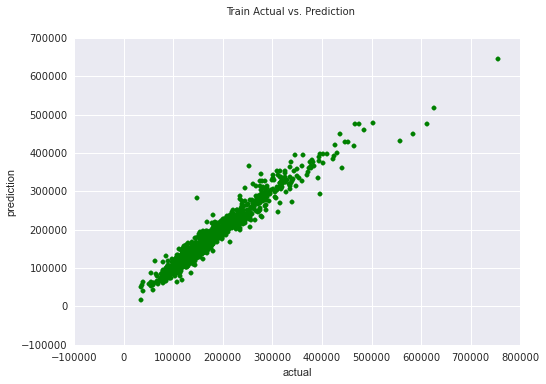

In [30]:
# Train actual vs prediction
plt.scatter(y_train, pred_train,  color='g')
plt.xlabel('actual')
plt.ylabel('prediction')
plt.suptitle('Train Actual vs. Prediction')

But when we use the test data to predict and plot it against the test actual it performs okay, but there are a handful of datapoints that make no sense. For example, an actual is 200,000 but predicted 850,000.

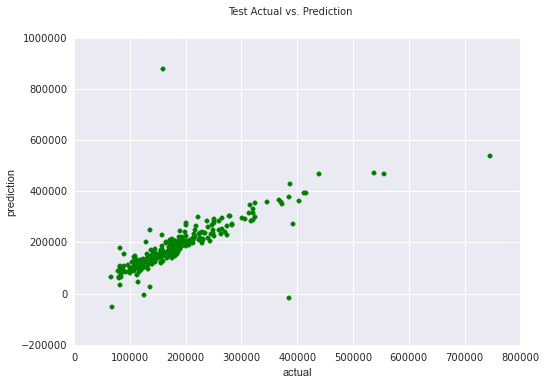

In [31]:
#Test actual vs prediction
plt.scatter(y_test, pred_test,  color='g')
plt.xlabel('actual')
plt.ylabel('prediction')
plt.suptitle('Test Actual vs. Prediction')

### Ridge Regression

This model is better than the simple linear regression because it shrinks variables to near zero.
Judging from the plots the test actual vs predicted has less far apart predictions. The one mentioned previously is still there though. Let's move on to use XGBoost to see if we can predict better than ridge and simple.

In [32]:
#ridge regression (.16 score)
from sklearn.linear_model import Ridge
rlm = Ridge(alpha=1.0)


#train on train set
rlm.fit(X_train,y_train)

#coefficients
coef_df = pd.DataFrame({'features':X_train.columns, 'coef':rlm.coef_})[['features','coef']]
print coef_df.sort_values(['coef'], ascending=[False])[:10] #high coef
print coef_df.sort_values(['coef'], ascending=[True])[:10] #low coef

#pred
pred_train = rlm.predict(X_train)
pred_test = rlm.predict(X_test)
print "\n"
print "Train RMSE:",error_metric(y_train,pred_train)
print "Test RMSE:", error_metric(y_test,pred_test)
print "\n"

                 features          coef
92        Condition2_Norm  60382.111334
91       Condition2_Feedr  41444.877758
116      RoofMatl_WdShngl  37685.057446
78   Neighborhood_StoneBr  34664.676551
93        Condition2_PosA  31881.133259
71   Neighborhood_NoRidge  31254.571720
90      Condition2_Artery  26167.096922
251          SaleType_CWD  25403.034708
112        RoofStyle_Shed  24416.710686
256          SaleType_New  22040.536700
                  features           coef
94         Condition2_PosN -163414.330343
114       RoofMatl_Tar&Grv  -24283.048575
264  SaleCondition_Partial  -20741.042850
32        MSZoning_C (all)  -20342.732835
113       RoofMatl_CompShg  -18617.381775
55           LandSlope_Sev  -18457.966135
236          GarageQual_Fa  -18412.919197
240          GarageQual_TA  -18081.633657
63    Neighborhood_Edwards  -17982.950870
67    Neighborhood_Mitchel  -16396.363737


Train RMSE: 19900.740454
Test RMSE: 48839.3582391




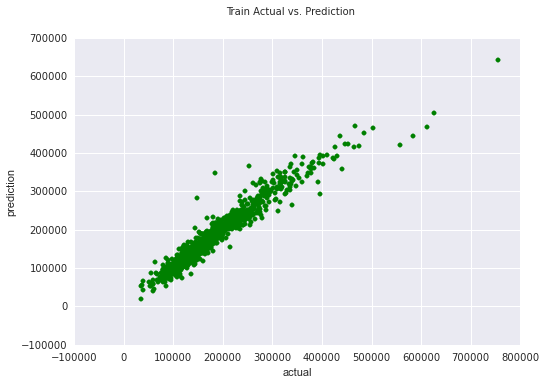

In [33]:
# Train actual vs prediction
plt.scatter(y_train, pred_train,  color='g')
plt.xlabel('actual')
plt.ylabel('prediction')
plt.suptitle('Train Actual vs. Prediction')

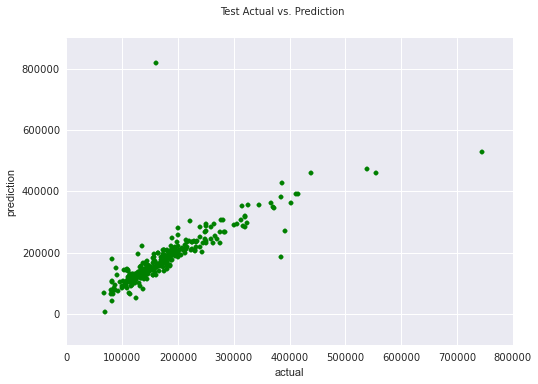

In [34]:
#Test actual vs prediction
plt.scatter(y_test, pred_test,  color='g')
plt.xlabel('actual')
plt.ylabel('prediction')
plt.suptitle('Test Actual vs. Prediction')

### XGBoost

We first try to find good cross validation parameters by searching 3 max depth, min child weight, and learning rate.  Note, the error metric is negative because of sklearn's objective function.

Based on the grid search the following parameters performed the best:

- learning_rate = 0.05
- subsample = 0.8
- max_depth = 7
- min_child_weight = 1

In [35]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

In [36]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5], 'learning_rate': [0.1, 0.01, 0.05]}
ind_params = {'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 
             'objective': 'reg:linear'}
optimized_GBM = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                            cv_params, 
                             scoring = 'mean_squared_error', cv = 5, n_jobs = -1)

In [37]:
optimized_GBM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01, 0.05], 'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [38]:
optimized_GBM.grid_scores_

[mean: -845900308.91004, std: 461125513.77616, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1},
 mean: -852353473.83360, std: 485287685.83821, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3},
 mean: -860561215.11773, std: 437803207.26903, params: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5},
 mean: -854309695.92370, std: 467813472.24067, params: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1},
 mean: -831504994.15739, std: 456489524.35600, params: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3},
 mean: -877582002.90156, std: 468868493.63148, params: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5},
 mean: -835522039.28035, std: 396706246.40271, params: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1},
 mean: -843257697.61240, std: 448272635.89929, params: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3},
 mean: -851252406.55608, std: 485960883.70199, params: {

In [39]:
optimized_GBM.best_score_

-766805991.47873068

To increase the performance of XGBoost’s speed through many iterations of the training set we use the XGBoost's API without sklearn. We create a DMatrix, it sorts the data initially to optimize for XGBoost when it builds trees, making the algorithm more efficient.

In [65]:
xgdmat = xgb.DMatrix(X_train, y_train)

Now we reset the parameters in a different syntax.

In [66]:
our_params = {'eta': 0.05, 'seed':0, 'subsample': 0.8, 
             'objective': 'reg:linear', 'max_depth':7, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['rmse','error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

The CV results are saved into a pandas df, so it is easy to see our results.

In [67]:
cv_xgb.tail(5)

,test-error-mean,test-error-std,test-rmse-mean,test-rmse-std,train-error-mean,train-error-std,train-rmse-mean,train-rmse-std
332,-180743.03125,4824.832538,27896.469531,5627.270979,-180743.034375,1206.204822,1428.649097,72.309661
333,-180743.03125,4824.832538,27895.816406,5626.543238,-180743.034375,1206.204822,1417.821948,69.785787
334,-180743.03125,4824.832538,27895.516797,5626.295699,-180743.034375,1206.204822,1405.614990,70.378571
335,-180743.03125,4824.832538,27895.508594,5625.336383,-180743.034375,1206.204822,1399.770264,71.084491
336,-180743.03125,4824.832538,27894.306641,5624.149089,-180743.034375,1206.204822,1388.360474,71.972447


Our CV mse at 336 iterations is 27894^2 = 778075236

Now that we have our best setting, we save my model.

In [68]:
our_params = {'eta': 0.05, 'seed':0, 'subsample': 0.8, 
             'objective': 'reg:linear', 'max_depth':7, 'min_child_weight':1} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 336)

There is a nifty function that shows the importance of each feature.

In [69]:
#plot top 20 important
importance = final_gb.get_fscore()
importance_df = pd.DataFrame({'feature':list(importance.keys()), 'f-score':list(importance.values())})
importance_df = importance_df.sort_values('f-score')[-20:]
importance_df

,f-score,feature
198,134,BsmtFinSF2
16,135,EnclosedPorch
85,244,YrSold
167,336,WoodDeckSF
57,337,2ndFlrSF
60,389,OverallCond
3,445,OpenPorchSF
15,450,YearRemodAdd
124,482,MoSold
168,493,MasVnrArea


We plot the important features by rank so it is easier to read. The top 5 features are:

- LotFrontage: Linear feet of street connected to property
- LotArea: Lot size in square feet
- MSSubClass: Identifies the type of dwelling involved in the sale.
- BsmtUnfSF: Unfinished square feet of basement area
- GrLivArea: Above grade (ground) living area square feet

The most important features are similar, they involve square feet. This makes sense because when buying a home people want the most square feet for their money.

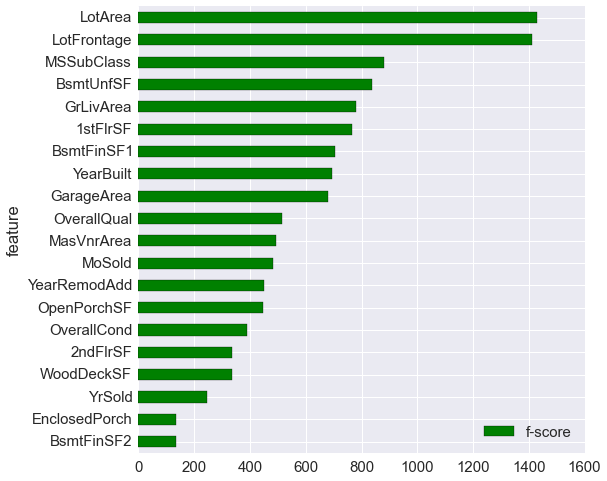

In [70]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)

importance_df.plot(kind = 'barh', x = 'feature', figsize = (8,8), color = 'green')

XGBoost model fits the data much better than the previous ones. There are still some bad predictions but they were not as bad as before.

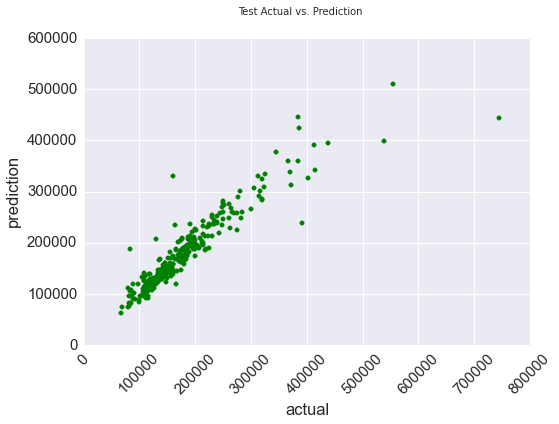

In [71]:
xgdmat_test = xgb.DMatrix(X_test)
pred_test = final_gb.predict(xgdmat_test)
#Test actual vs prediction
plt.scatter(y_test, pred_test,  color='g')
plt.xlabel('actual')
plt.xticks(rotation = 45)
plt.ylabel('prediction')
plt.suptitle('Test Actual vs. Prediction')

# Conclusion

The models created can accurately predict the sale price, but XGBoost predicts it the best out of the three. The predictions were submitted to Kaggle and these were the results:

- Simple Linear Regression Model: 0.20085
- Ridge Regression Model: 0.16460
- XGBoost Model: 0.13792

Based on the submission scores XGBoost performed the best since it has the lowest score. There are definitely other ways to improve the XGBoost model through feature engineering.

As of now, we learned how to implement the basic functionality of XGBoost library. It was quick to train and produced great results while ranking features by importance.

In [72]:
test_id = test.iloc[:,0]
xgdmat_test_dum = xgb.DMatrix(test_dum)
pred = final_gb.predict(xgdmat_test_dum)

In [73]:
submission = pd.DataFrame({'Id':test_id,'SalePrice':pred})
submission.loc[submission['SalePrice']<0,'SalePrice'] = 0
submission.to_csv('xgb_submission_final.csv',index = False)